# NLP Club: Deep learning with TensorFlow and Keras

In this notebook we'll go through the basics of neural networks and their main components and mechanisms. We'll not focus on the theoretical foundations. A great resource for the foundations is [this course.](https://www.nlpdemystified.org/course/neural-networks-1)

We'll use the tensorflow (tf) framework and utilize Keras, which builds upon tf and offers a pretty easy-to-use API for tf.

This notebook closely follows [this one here.](https://github.com/nitinpunjabi/nlp-demystified/blob/main/notebooks/nlpdemystified_neural_networks_foundations.ipynb)

In [173]:
## Update Spacey and download the small english statistical language model

# !pip install -U spacy==3.*
# !python -m spacy download en_core_web_sm

In [2]:
## import libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import spacy
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split

# Getting Data

In [3]:
## Get data
reviews = pd.read_csv("../../spotify_review_project/data/final/reviews_clean.csv")

In [4]:
reviews.head()

,Unnamed: 0,Review,Rating,Sentiment
0,0,Great music service the audio is high quality ...,5,positive
1,1,Please ignore previous negative rating This ap...,5,positive
2,2,This popup Get the best Spotify experience on ...,4,positive
3,3,Really buggy and terrible to use as of recently,1,negative
4,4,Dear Spotify why do I get songs that I did not...,1,negative


# Tokenization

In [5]:
## We disable NER and parsing to speed up processing
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser'])

In [6]:
def spacy_tokenizer(doc):
  return [t.lemma_.lower() for t in nlp(doc) if \
          len(t) > 2 and \
          not t.is_punct and \
          not t.is_space and \
          not t.is_stop and \
          t.is_alpha]

In [7]:
def preprocess_text(text):
  tokens = spacy_tokenizer(text)
  return "|".join(tokens)

In [8]:
## This takes a few minutes
## There's a non-string entry so we need to convert it with astype to avoid errors
preprocessed_corpus = [preprocess_text(post) for post in reviews.Review.astype(str)]

In [10]:
print(preprocessed_corpus[0])
print(preprocessed_corpus[111])

great|music|service|audio|high|quality|app|easy|use|quick|friendly|support
spotify|literally|account|come|good|music|experience|easy|use|feature|honestly|realize|need|get|recommend|apple|music|aesthetically|pleasing|way|well|feature|spotify|premium|ad|good


In [12]:
train_data, val_data, train_labels, val_labels = train_test_split(preprocessed_corpus, reviews.Sentiment, train_size=0.80, random_state=42)
val_data, test_data, val_labels, test_labels = train_test_split(val_data, val_labels, train_size=0.50, random_state=42)


In [13]:
print("Training Data:", len(train_data))
print("Validation Data:", len(val_data))
print("Test Data:", len(test_data))

Training Data: 49076
Validation Data: 6135
Test Data: 6135


In [19]:
tokenizer = keras.preprocessing.text.Tokenizer(filters="", lower=False, split='|', oov_token='OOV')

In [20]:
tokenizer.fit_on_texts(train_data)

In [59]:
#tokenizer.get_config()

In [38]:
print(f"Vocabulary size: {len(tokenizer.word_index)}")

Vocabulary size: 23430


# Vectorization

In [39]:
# Vectorize the first post using binary. We're using [:1] here because the 
# tokenizer expects an *array* of sequences.
print(train_data[:1])

# The resulting binary BoW has a 1 set for every word present in the sequence.
binary_bow = tokenizer.texts_to_matrix(train_data[:1])
print(f"Vector shape: {binary_bow.shape}")
print(binary_bow)

['great|podcast']
Vector shape: (1, 23431)
[[0. 0. 0. ... 0. 0. 0.]]


In [40]:
present_tokens = np.where(binary_bow[0] == 1)[0]
print(f"Token indices: {present_tokens}")
print(" ".join(tokenizer.index_word[n] for n in present_tokens))

Token indices: [16 24]
great podcast


In [25]:
tfidf_bow = tokenizer.texts_to_matrix(train_data[:1], mode='tfidf')
print(tfidf_bow, '\n')

# https://numpy.org/doc/stable/user/basics.indexing.html
print(f"TF-IDF scores of the first post's tokens:\n {tfidf_bow[0][present_tokens]}")

[[0. 0. 0. ... 0. 0. 0.]] 

TF-IDF scores of the first post's tokens:
 [2.30488067 2.7415456 ]


In [41]:
## Force to run on CPU to avoid errors
with tf.device('/CPU:0'):
    X_train_bow = tf.sparse.from_dense(tokenizer.texts_to_matrix(train_data))
    X_train_tfidf = tf.sparse.from_dense(tokenizer.texts_to_matrix(train_data, mode='tfidf'))


In [42]:
print("Shape of one-hot BoW:", tf.shape(X_train_bow))
print("Shape of TF-IDF BoW:", tf.shape(X_train_tfidf))

Shape of one-hot BoW: tf.Tensor([49076 23431], shape=(2,), dtype=int32)
Shape of TF-IDF BoW: tf.Tensor([49076 23431], shape=(2,), dtype=int32)


In [43]:
print(train_labels)

27988    positive
32871    negative
44795    negative
38406    negative
30912    negative
           ...   
54343    negative
38158    negative
860      negative
15795    positive
56422    positive
Name: Sentiment, Length: 49076, dtype: object


In [44]:
label_map = {"negative": 0, "positive": 1}
y_train = [label_map[label] for label in train_labels]
y_train = tf.convert_to_tensor(y_train)
print(y_train)
print("Shape of training labels:", y_train.shape)

tf.Tensor([1 0 0 ... 0 1 1], shape=(49076,), dtype=int32)
Shape of training labels: (49076,)


In [45]:
with tf.device('/CPU:0'):
    X_val_bow = tf.sparse.from_dense(tokenizer.texts_to_matrix(val_data))
    X_val_tfidf = tf.sparse.from_dense(tokenizer.texts_to_matrix(val_data, mode="tfidf"))
    X_test_bow = tf.sparse.from_dense(tokenizer.texts_to_matrix(test_data))
    X_test_tfidf = tf.sparse.from_dense(tokenizer.texts_to_matrix(test_data, mode="tfidf"))
    
y_val = [label_map[label] for label in val_labels]
y_test = [label_map[label] for label in test_labels]
y_val = tf.convert_to_tensor(y_val)
y_test = tf.convert_to_tensor(y_test)

## Model 1: BoW
* 2 fully connected layers with 128 units

In [46]:
NUM_CLASSES = 1 # one binary class
NUM_UNITS = 128

# "set_seed" is called to ensure we get the same weights every time. Comment out this
# line to get different weight initializations.
tf.random.set_seed(42)

# "kernel_initializer" is passed to ensure we get the same weights every time. Remove
# the parameter to get different weight initializations.
model1_bow = keras.Sequential([
  layers.Dense(NUM_UNITS, activation='relu', kernel_initializer=tf.keras.initializers.random_normal(seed=42)),
  layers.Dense(NUM_UNITS, activation='relu', kernel_initializer=tf.keras.initializers.random_normal(seed=42)),
  layers.Dense(NUM_CLASSES, activation='sigmoid', kernel_initializer=tf.keras.initializers.random_normal(seed=42))
  ])

In [47]:
model1_bow.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [48]:
NUM_EPOCHS = 15
BATCH_SIZE = 128

with tf.device('/GPU:0'):
    history = model1_bow.fit(X_train_bow, y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val_bow, y_val))

Epoch 1/15


C:\Users\dominik.freunberger\AppData\Roaming\Python\Python310\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_1/dense_3/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_1/dense_3/embedding_lookup_sparse/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_1/dense_3/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


384/384 [==============================] - 5s 10ms/step - loss: 0.3761 - accuracy: 0.8462 - val_loss: 0.3649 - val_accuracy: 0.8504
Epoch 2/15
384/384 [==============================] - 3s 9ms/step - loss: 0.3158 - accuracy: 0.8760 - val_loss: 0.3661 - val_accuracy: 0.8481
Epoch 3/15
384/384 [==============================] - 4s 9ms/step - loss: 0.2948 - accuracy: 0.8858 - val_loss: 0.3754 - val_accuracy: 0.8522
Epoch 4/15
384/384 [==============================] - 3s 9ms/step - loss: 0.2769 - accuracy: 0.8939 - val_loss: 0.3683 - val_accuracy: 0.8505
Epoch 5/15
384/384 [==============================] - 4s 9ms/step - loss: 0.2587 - accuracy: 0.9023 - val_loss: 0.3766 - val_accuracy: 0.8520
Epoch 6/15
384/384 [==============================] - 4s 11ms/step - loss: 0.2396 - accuracy: 0.9113 - val_loss: 0.3882 - val_accuracy: 0.8513
Epoch 7/15
384/384 [==============================] - 4s 11ms/step - loss: 0.2205 - accuracy: 0.9200 - val_loss: 0.3995 - val_accuracy: 0.8471
Epoch 8/15
384

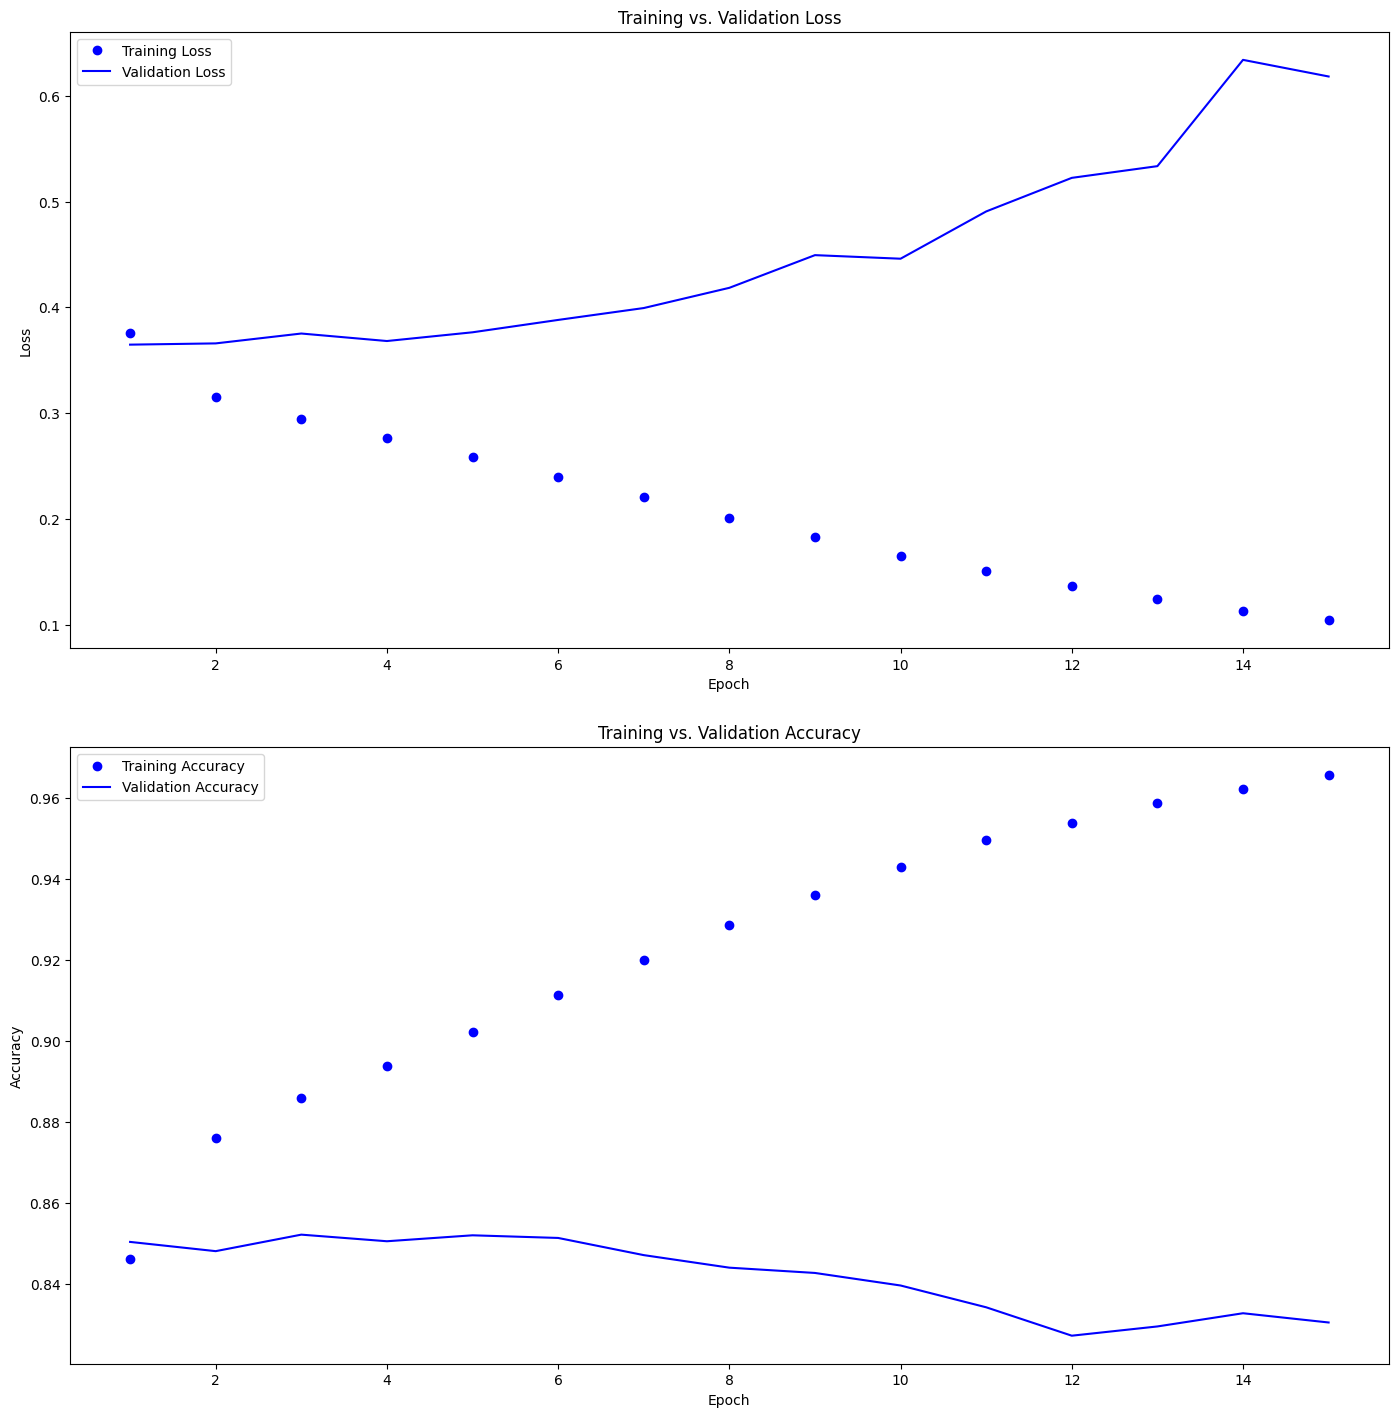

In [49]:
training_losses = history.history['loss']
validation_losses = history.history['val_loss']

training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

epochs = range(1, len(training_losses) + 1)

fig, (ax1, ax2) = plt.subplots(2)
fig.set_figheight(15)
fig.set_figwidth(15)
fig.tight_layout(pad=5.0)

# Plot training vs. validation loss.
ax1.plot(epochs, training_losses, 'bo', label='Training Loss')
ax1.plot(epochs, validation_losses, 'b', label='Validation Loss')
ax1.title.set_text('Training vs. Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# PLot training vs. validation accuracy.
ax2.plot(epochs, training_accuracy, 'bo', label='Training Accuracy')
ax2.plot(epochs, validation_accuracy, 'b', label='Validation Accuracy')
ax2.title.set_text('Training vs. Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()

In [50]:
model1_bow.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               2999296   
                                                                 
 dense_4 (Dense)             (None, 128)               16512     
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 3,015,937
Trainable params: 3,015,937
Non-trainable params: 0
_________________________________________________________________


In [36]:
# Size of vocabulary. The '+ 1' is because the zero index is reserved for padding.
v = (len(tokenizer.word_index) + 1)
print(f"Size of vocabulary/number of columns in BoW array (v): {v}")

n = NUM_UNITS
print(f"Number of units in the first layer(n): {n}\n")

# The '+ n' accounts for the number of biases. Each unit has one.
p = v * n + n
print(f"Number of params in the first layer(p) = v * n + n = {p}")

Size of vocabulary/number of columns in BoW array (v): 23431
Number of units in the first layer(n): 128

Number of params in the first layer(p) = v * n + n = 2999296


In [51]:
results = model1_bow.evaluate(X_val_bow, y_val)
print(f"Validation loss: {results[0]}")
print(f"Validation accuracy: {results[1]}")

192/192 [==============================] - 1s 6ms/step - loss: 0.6182 - accuracy: 0.8305
Validation loss: 0.6182442307472229
Validation accuracy: 0.8304808735847473


In [52]:
y_pred_probs = model1_bow.predict(X_val_bow, verbose=1)
y_pred_probs

192/192 [==============================] - 1s 4ms/step


array([[0.95527786],
       [0.99990785],
       [0.09188084],
       ...,
       [0.97099   ],
       [0.9992322 ],
       [0.59597415]], dtype=float32)

In [54]:
y_preds = (y_pred_probs >= .5).astype(int)
print(y_preds)

[[1]
 [1]
 [0]
 ...
 [1]
 [1]
 [1]]


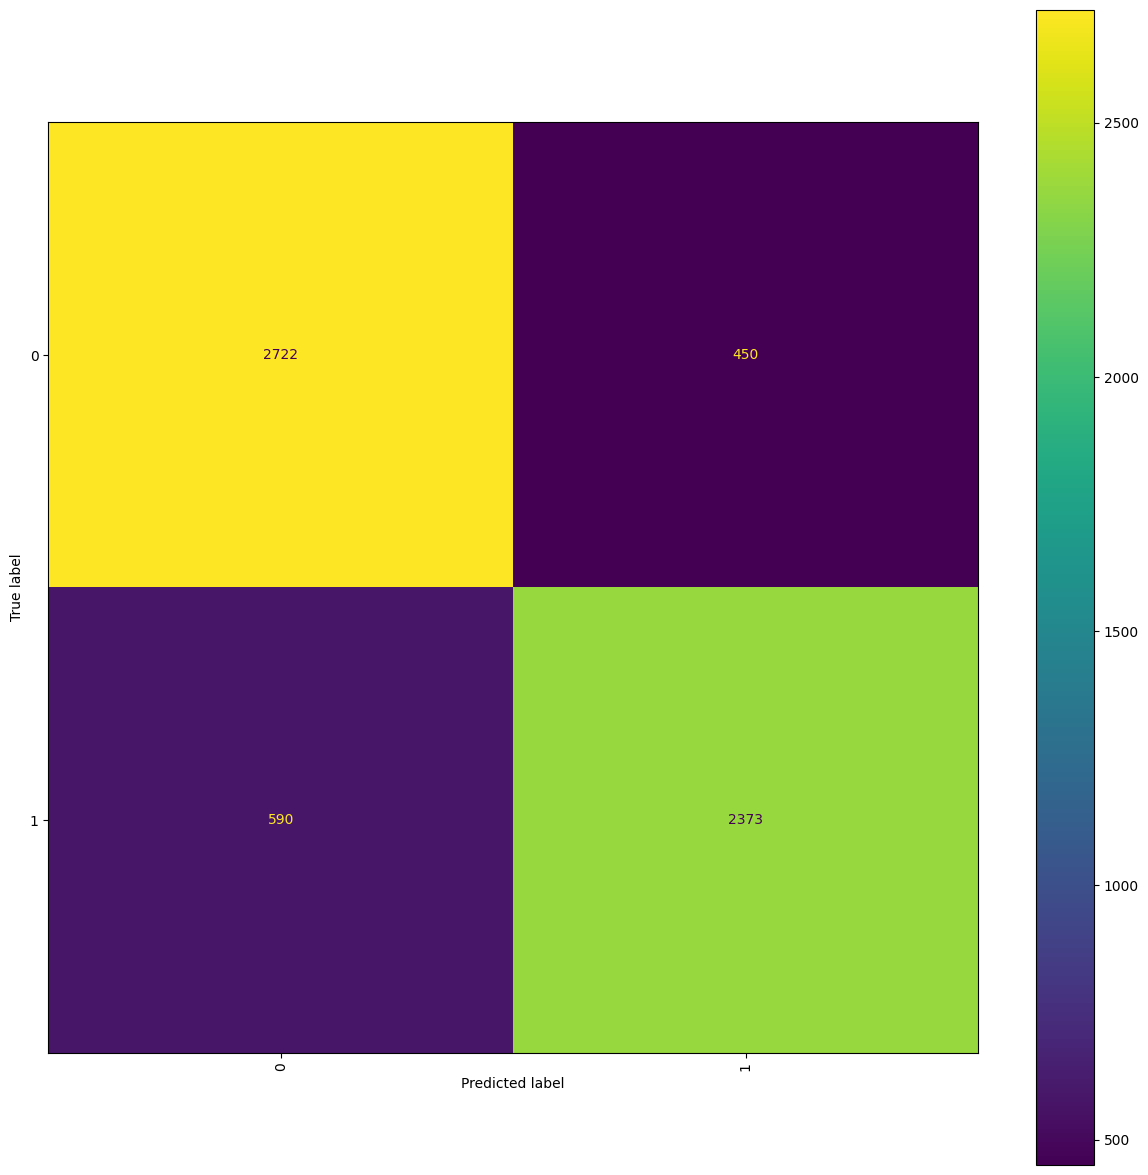

In [56]:
cm = confusion_matrix(y_val, y_preds)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(15, 15))
cmd.plot(ax=ax, xticks_rotation='vertical')

# Model 1: TF-IDF
* 2 fully connected layers with 128 units


In [285]:
NUM_CLASSES = 1 # one binary class
NUM_UNITS = 128

# "set_seed" is called to ensure we get the same weights every time. Comment out this
# line to get different weight initializations.
tf.random.set_seed(42)

# "kernel_initializer" is passed to ensure we get the same weights every time. Remove
# the parameter to get different weight initializations.
model1_tfidf = keras.Sequential([
  layers.Dense(NUM_UNITS, activation='relu', kernel_initializer=tf.keras.initializers.random_normal(seed=42)),
  layers.Dense(NUM_UNITS, activation='relu', kernel_initializer=tf.keras.initializers.random_normal(seed=42)),
  layers.Dense(NUM_CLASSES, activation='sigmoid', kernel_initializer=tf.keras.initializers.random_normal(seed=42))
  ])

In [286]:
model1_tfidf.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [287]:
NUM_EPOCHS = 15
BATCH_SIZE = 128

history = model1_tfidf.fit(X_train_tfidf, y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val_tfidf, y_val))

Epoch 1/15


C:\Users\dominik.freunberger\AppData\Roaming\Python\Python310\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_29/dense_100/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_29/dense_100/embedding_lookup_sparse/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_29/dense_100/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


384/384 [==============================] - 4s 9ms/step - loss: 0.3825 - accuracy: 0.8441 - val_loss: 0.3661 - val_accuracy: 0.8530
Epoch 2/15
384/384 [==============================] - 3s 8ms/step - loss: 0.3069 - accuracy: 0.8829 - val_loss: 0.3761 - val_accuracy: 0.8502
Epoch 3/15
384/384 [==============================] - 3s 8ms/step - loss: 0.2773 - accuracy: 0.8957 - val_loss: 0.3857 - val_accuracy: 0.8543
Epoch 4/15
384/384 [==============================] - 3s 8ms/step - loss: 0.2489 - accuracy: 0.9069 - val_loss: 0.3747 - val_accuracy: 0.8458
Epoch 5/15
384/384 [==============================] - 3s 8ms/step - loss: 0.2210 - accuracy: 0.9188 - val_loss: 0.4013 - val_accuracy: 0.8471
Epoch 6/15
384/384 [==============================] - 3s 8ms/step - loss: 0.1900 - accuracy: 0.9306 - val_loss: 0.4544 - val_accuracy: 0.8407
Epoch 7/15
384/384 [==============================] - 3s 8ms/step - loss: 0.1603 - accuracy: 0.9428 - val_loss: 0.4824 - val_accuracy: 0.8310
Epoch 8/15
384/38

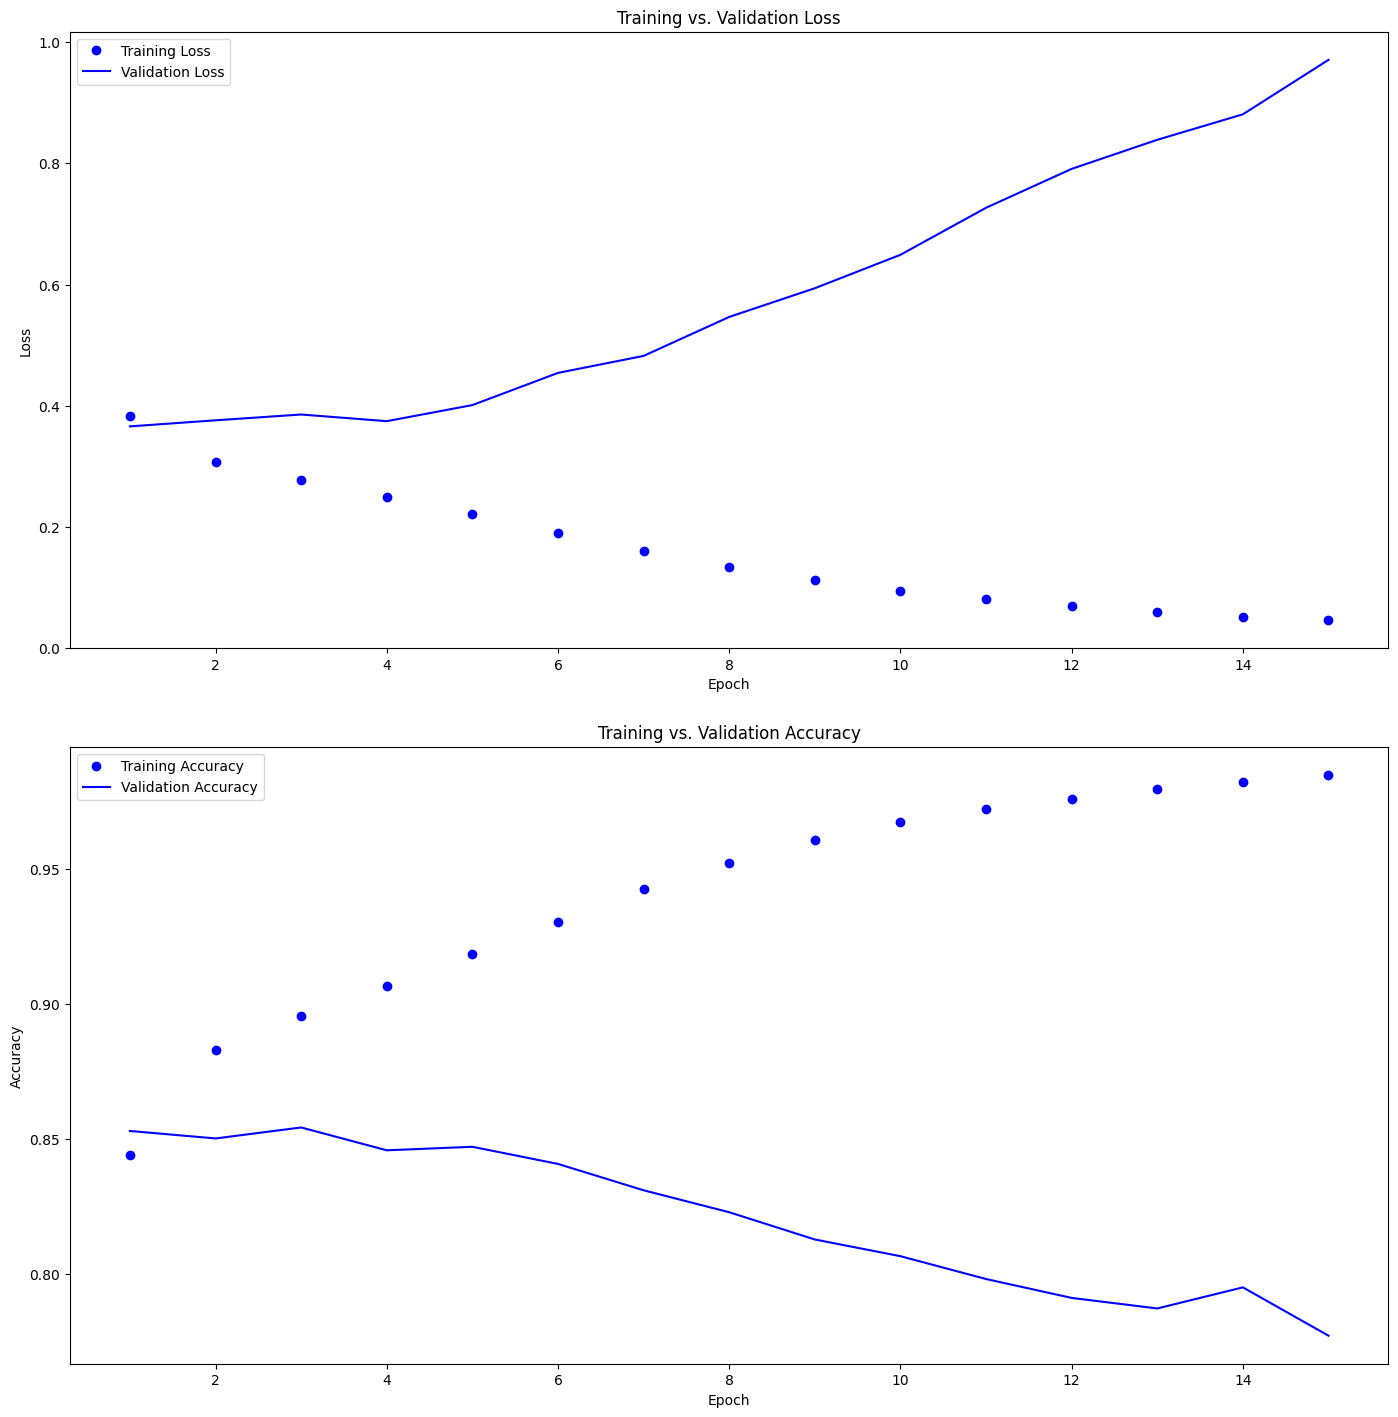

In [288]:

training_losses = history.history['loss']
validation_losses = history.history['val_loss']

training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

epochs = range(1, len(training_losses) + 1)

fig, (ax1, ax2) = plt.subplots(2)
fig.set_figheight(15)
fig.set_figwidth(15)
fig.tight_layout(pad=5.0)

# Plot training vs. validation loss.
ax1.plot(epochs, training_losses, 'bo', label='Training Loss')
ax1.plot(epochs, validation_losses, 'b', label='Validation Loss')
ax1.title.set_text('Training vs. Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

# PLot training vs. validation accuracy.
ax2.plot(epochs, training_accuracy, 'bo', label='Training Accuracy')
ax2.plot(epochs, validation_accuracy, 'b', label='Validation Accuracy')
ax2.title.set_text('Training vs. Validation Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()

In [289]:
model1_tfidf.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_100 (Dense)           (None, 128)               2999296   
                                                                 
 dense_101 (Dense)           (None, 128)               16512     
                                                                 
 dense_102 (Dense)           (None, 1)                 129       
                                                                 
Total params: 3,015,937
Trainable params: 3,015,937
Non-trainable params: 0
_________________________________________________________________


In [290]:
results = model1_tfidf.evaluate(X_val_bow, y_val)
print(f"Validation loss: {results[0]}")
print(f"Validation accuracy: {results[1]}")

192/192 [==============================] - 1s 5ms/step - loss: 0.4997 - accuracy: 0.7759
Validation loss: 0.4996850788593292
Validation accuracy: 0.7758761048316956


In [304]:
y_pred_probs = model1_bow.predict(X_val_bow, verbose=1)
y_preds = (y_pred_probs >= .5).astype(int)
print(y_preds)

192/192 [==============================] - 1s 4ms/step
[[0]
 [1]
 [0]
 ...
 [0]
 [1]
 [0]]


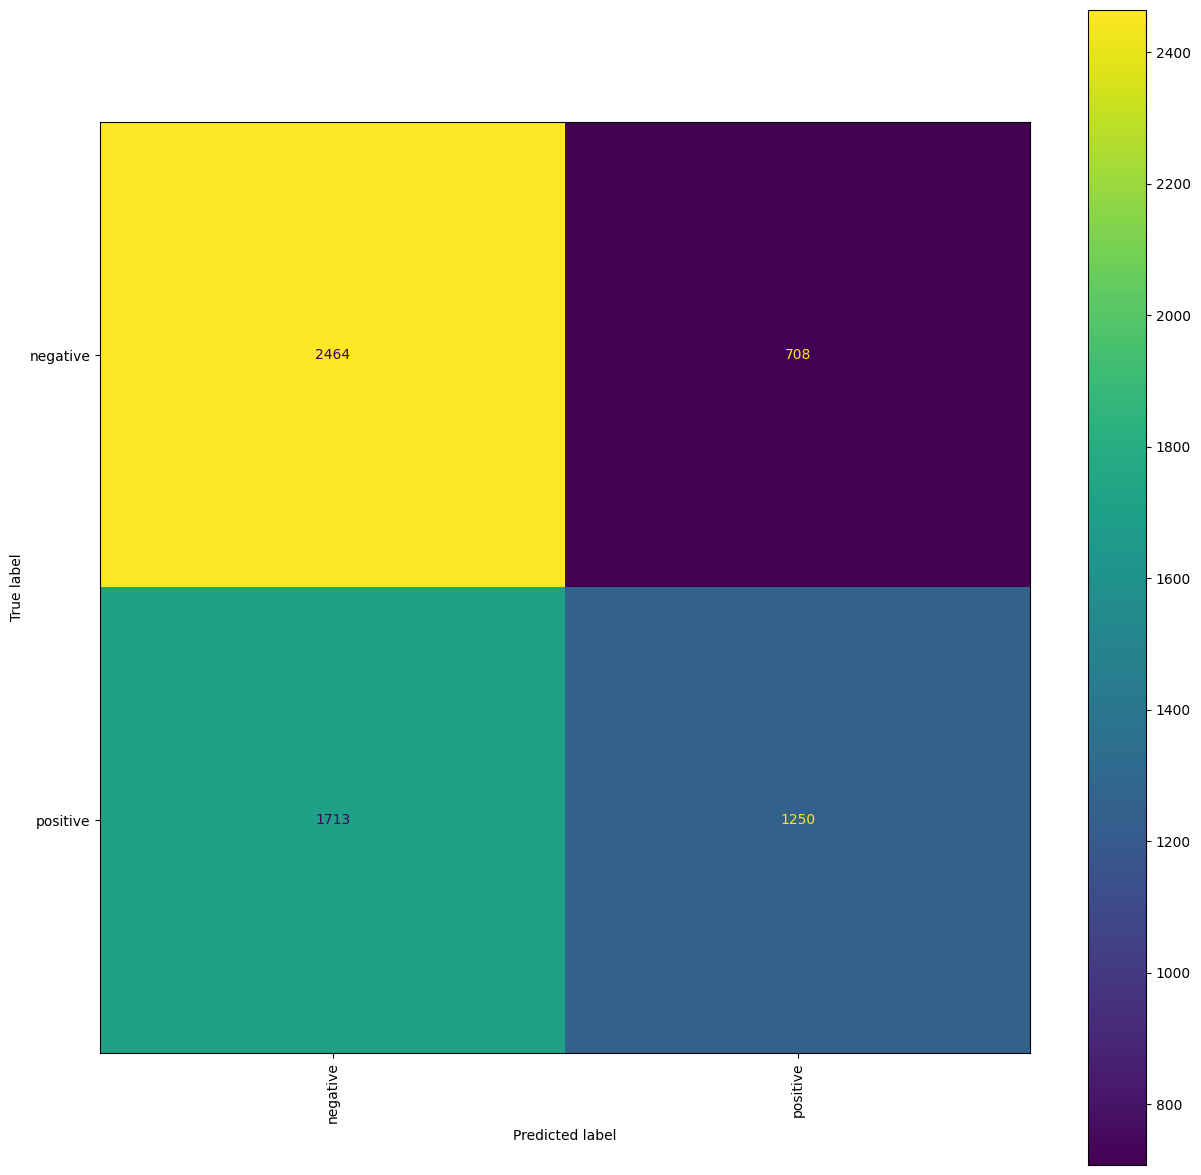

In [305]:
cm = confusion_matrix(y_val, y_preds)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_map)
fig, ax = plt.subplots(figsize=(15, 15))
cmd.plot(ax=ax, xticks_rotation='vertical')

# Model 2: BoW
* 3 fully connected layers with 128 units
* Dropout layer
* Early Stopping/Callback

In [57]:
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1)

tf.random.set_seed(0)
initializer = tf.keras.initializers.HeNormal(seed=42)

model2_bow = keras.Sequential([
  layers.Dense(NUM_UNITS, activation='relu', kernel_initializer=initializer),
  layers.Dense(NUM_UNITS, activation='relu', kernel_initializer=initializer),
  layers.Dense(NUM_UNITS, activation='relu', kernel_initializer=initializer),
  layers.Dropout(0.3),
  layers.Dense(NUM_CLASSES, activation='sigmoid')
])

model2_bow.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

with tf.device('/GPU:0'):
  history = model2_bow.fit(X_train_bow, y_train, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE, validation_data=(X_val_bow, y_val), callbacks=[es_callback])

Epoch 1/15


C:\Users\dominik.freunberger\AppData\Roaming\Python\Python310\site-packages\tensorflow\python\framework\indexed_slices.py:444: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("gradient_tape/sequential_2/dense_6/embedding_lookup_sparse/Reshape_1:0", shape=(None,), dtype=int32), values=Tensor("gradient_tape/sequential_2/dense_6/embedding_lookup_sparse/Reshape:0", shape=(None, 128), dtype=float32), dense_shape=Tensor("gradient_tape/sequential_2/dense_6/embedding_lookup_sparse/Cast:0", shape=(2,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


384/384 [==============================] - 5s 11ms/step - loss: 0.3659 - accuracy: 0.8518 - val_loss: 0.3656 - val_accuracy: 0.8491
Epoch 2/15
384/384 [==============================] - 4s 11ms/step - loss: 0.3112 - accuracy: 0.8791 - val_loss: 0.3598 - val_accuracy: 0.8522
Epoch 3/15
384/384 [==============================] - 4s 11ms/step - loss: 0.2821 - accuracy: 0.8917 - val_loss: 0.3784 - val_accuracy: 0.8517


In [58]:
results = model2_bow.evaluate(X_val_bow, y_val)
print(f"Test loss: {results[0]}")
print(f"Test accuracy: {results[1]}")

192/192 [==============================] - 1s 7ms/step - loss: 0.3784 - accuracy: 0.8517
Test loss: 0.3783975839614868
Test accuracy: 0.8516707420349121


In [310]:
y_pred_probs = model2_bow.predict(X_val_bow, verbose=1)
y_preds = (y_pred_probs >= .5).astype(int)

192/192 [==============================] - 1s 3ms/step


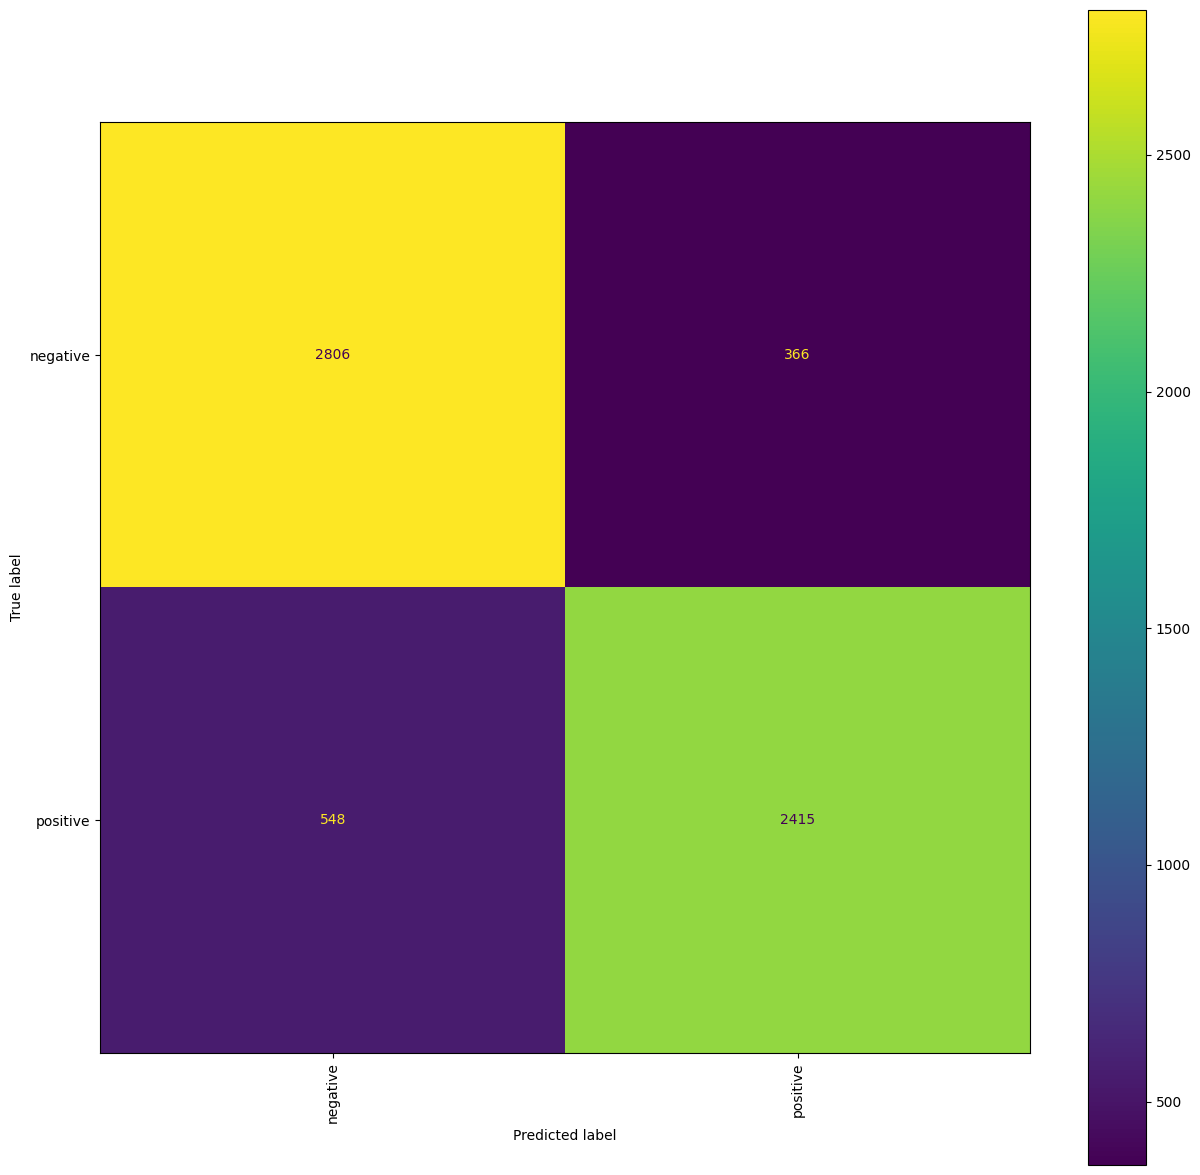

In [311]:
cm = confusion_matrix(y_val, y_preds)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_map)
fig, ax = plt.subplots(figsize=(15, 15))
cmd.plot(ax=ax, xticks_rotation='vertical')

In [312]:
print(classification_report(y_val, y_preds, target_names=label_map))

              precision    recall  f1-score   support

    negative       0.84      0.88      0.86      3172
    positive       0.87      0.82      0.84      2963

    accuracy                           0.85      6135
   macro avg       0.85      0.85      0.85      6135
weighted avg       0.85      0.85      0.85      6135

